## Notes
### 6/18/20
- Value of unity should just mean one, which is good.
- Set up code for two parameterizations of charge generation + seperation, the first being noninductive and the second being inductive, which together should account for almost all charge. It'll also be interesting to see how much the inductive process contributes, since it's not really considered that important, yet still important enough to include here.
- Had to search around to figure out what constants were in the equations and finding their exact values. Still a few to go.


### 6/22/20
- Since these differential equations are dependent on time, it may not be necessary to solve complete solve them. When model is working, hopefully there is a sign reversal between -10 and -21 degrees C.
- Their expression for temperature is weirdly complicated, but since I'm only doing a one-dimensional model, mine can be simpler. It's F(tau)= a tau^3 + b tau^2 + c tau + d, where tau = (-21/T_r)(T-273.16) and T_r = -21 or T_r = -10. This implies a conversion to Kelvin. I'll stick with my current temperature function, and if it doesn't work, then I'll try incorporating their stuff.

### 6/23/20
- Found graupel drag coefficient from the book: Parameterization Schemes: Keys to Understanding Numerical Weather Prediction by Stensrud.
- Looked around to find what the intercept parameters for graupel and snow are, which turns on you need a distribution describing their size. Lambda (I used Y_g) is the slope, which is apparently almost never constant. However, the textbook that explained it (Storm and Cloud Dynamics, Cotton & Anthes) pretended the slope was constant for their example, and in some cases it kind of it, so I will just make it constant.
- How to even know what that constant is? Cotton & Anthes gave the equation: $Y_g = 2.67 * 10^3 * M_g^{-1/3}$. M_g stands for graupel water content, so I searched for what value that might be. Turns out it usually is around 0.5, 1, or 2 g m^-3. Since 1 seems like a simple, midrange option, that's what I'm going with.
- But what about the intercept parameter? According to paper Diagnosing the Intercept Parameter for Exponential Raindrop Size Distribution Based on Video Disdrometer Observations: Model Development (Zhang 2008), the most common value for $n_{0g} = 8 \times 10^6$ m^-4. Another weird unit in meteorology that I'm sure makes sense but is still strange.
- The Zhang 2008 paper has a really nice graph showing the dropsize distribution vs diameter. The range of diameter for graupel is 0 to 5 mm, so I think I'm going to make an array of those values for the graupel distribution.
- This doesn't give me exact distibution I think is ideal, which starts which a good amount of graupel near 0, then peaks at around 1, and slowly goes decreases until it's nearly zero at 5. However, I do have the a lot of 0 mm graupel, and it does go to nearly zero around 5 mm, so it's not awful.

### 6/25/20
- I don't know how I'm going to deal with $ \rho_a$, the air density at altitude. Obviously altitude is changing. So that's probably going to be an array, and the charge separation equation will give something for every air density in the array. Which I think is what I want, something that describes the charge changing as altitude changes. 
- Found this familiar equation: $\rho = \frac{\rho_0 M}{RT_0}(1 - \frac{Lh}{T_0})^{gM/RL-1}$. That'll be my model for how air density changes with altitude, which is $h$. The rest is easy. Wel'll pretend it's 297 K out (it should be at least pretty warm if there are going to be thunderstorms)
- Density function was being weird, so moved it up my code by altitude. Also had desnity increasing with altitude for a little while was bad, but that was just due to misplaced parenthesis and is fixed.
- Did some dimensional analysis to check the density units I get, which are kg/m^3, which is good.
- Changed N_1 to N_i, misread blurry PDF paper. Double checking  values for P_l (where did 300 come from again?) and finding N_i are what's necessary next.

### 6/29/20
- Checked the value for P_l (graupel density) again. According to the Handbook of Atmospheric Electrodynamics (Volland 1995) and confirmed by other sources, graupel density in thunderstorms range from 0.1 to 1.0 gm/cm^3. If I go with an average-ish of 0.5, that means it's $500 \mathrm{kg/m^3}$, which is the same magnitude as 300, so I guess my original value was that off. However, that still seems like a really high density.
- For N_i, the number seems to vary widely, from 10^2 to 10^6 ice crystals/liter, with amounts usually around 10^4/L, so I'll try that. Have to convert per L to per m^3 though,  which means it's $10^7 \mathrm{m^{-3}}$.
- And fortunately when I put the numbers in the equation, it works, but I don't think I'm at the point where it's actually meaningful yet. I plotted the array, but it automatically does it versus density, which isn't what I want.
- Changed it to versus Z. 

### 6/30/20
- Air density is fixed. It was a really stupid mistake. But now it's right, and I confirmed it with other sources.
- This is minor, but I also realized it would make a lot more sense if I moved notes to the top of the document instead of the middle.
- Back to the whole graupel density thing. In another diagnosis paper, Incorporating Diagnosed Intercept Parameters... (Pan 2016), it mentioned graupel particle density as $400 \: \mathrm{kg/m^3}$. Maybe we feel slightly better about this since the density of air is not longer $300 \: \mathrm{kg/m^3}$. 
- All graphs have labels and titles now. 
- Was looking at my graupel distribution plot with its newly correct x-axis and compared it to Zhang 2008. They looked unsettlingly different, but then I realized theirs had log scale, so I put a logscale on my, and everything looks good now.

### 7/1/20
- Looked for papers that calculated amount of charge generated like my final result. The closest thing I've seen is in Mansell 2010 $ \mathrm{C \: minute^{-1} \: level^{-1}} $ in which their volume was a level, which was 125 m thick. However, it was a 2D model, and I'm not entirely sure what length they used. The charge varied horizontally across the level, so I'm assuming it was parametrized, but as there was no horizontal scale, there's not much I can gather from it.  Basically, the problem is that other models are so much more complex than mine that I don't even know how to compare results. I've looked through five other papers and haven't seen anything helpful, so I could keep looking, or I could just continue with my model.
- Ziegler (1991) has nC/m^3, which is also close to mine, but I'm not sure what time it's over, and it's also 2D, so I don't know how I would compare mine.
- The next step is adding in the charge magnitude, which I'm not entirely sure how to do that. But I could have it correspond to temperture, and some assign a range of temperature to be positive and negative. How I will actually do that is for another day.

### 7/9/20
- Found a paper going over various parameters for a model like this, and their dq = $1.6 * 10^{-14}$ C/collision. I'll try that.
- At -10.75 degrees, the altitude is 5.5 km. Sign reversal temperature can vary depending on liquid water content (-10 to -21 degrees). I'll try around -10 for now.
- Below -10.75 it's negative, and everything about is positive now. Took forever to figure out how to do that, and the way I did it is probably really dumb, but it worked. Plotted an interesting new graph. I have to figure out how I want to account for the small region of positive charge at the bottom of the cloud too. The question I have is where would I do that? I haven't found values for the temperature reversal. Maybe I'll just guestimate at one kilometer?
- It's done, and the graph looks funny. We'll see how right this is, but it did what I wanted at least.

### 7/10/20
- Improved code for making part of the array negative. Added the hyperbolic tangent function to smooth out the curve.
- Scavazzo's 1998 paper, A Numerical Study of Thundercloud Electrification went into some depth about their particle concentrations, which was pretty helpful. Ice crystal concentration increases with height, heavier precipitation (like graupel) decreases with altitude. Makes sense. Have to still add code into model and hope I can make it work. However, they're also described as an exponential with the form $Ae^{Bz}$, where A and B are class numbers corresponding to particle characteristics. B is positive for ice crystals, and negative for graupel probably. What is A? And the exact value of B? I have no idea. Were these values recorded in the appendix of the paper? No.
- Apparently cloud base is around 2 km.

### 7/13/20 
- So cloud base can range anywhere from 0.5 to 4 km. Will stick with 2 km for now.
- Scavazzo paper led me to Pruppacher and Klett's Microstructure of Atmospheric Clouds and Precipitation, which is full of information, but of course not exactly what I want. Their one figure show ice crystal concentration vs. altitude ends at 2.5 km, so that's disappointing. The only other relevent reference was a textbook they cited, Cloud Physics by Rogers and Yau, but it's only for sale, and I wasn't able to find any free PDF version, so I can't use it. Feels like a lot of searching in vain, since I'm just going to come up with my own function and hope for the best.

### 7/14/20
- Started with ice crystal concentration. Made an exponential function with an average value around 10^7, played around until I got something that increased gradually and corresponded to freezing temperature. Definitely willing to change and alter it, but it's something to start with. 
- Ran it through my code, and now charge generation is way off. And even the part where I change the magnitude no longer makes any sense, so that's great. So ice crystal concentration affects charge generation really strongly (which make sense, since the entire equation is just multiplied by N_i, and an exponential that varies greatly with altitude is going to make everything at small values basically trivial. So I should probably maybe do a more casual linear slope? or a 1 - exp(x) type of expression.
- Graupel density function ruins the charge generation function less, which is good. I tried having centered-ish around a density of 300 kg/m^3. I still get a sensible sign flip and substantial amount of charge at the bottom of the storm. However, charge generation is now peaking at the bottom of the cloud, which isn't really what I want.
- The ideal function for graupel density would be an actual gaussian that peaks around the freezing point. Will work on refining that later.
- Combining both still results in the charge generation disaster.
- I want to also start cutting off my storm so it only exists from 2 km to 10 km. Going to make the linspace interval smaller since it's only in increments of half a kilometer, which is pretty large.

### 7/15/20
- Making the graupel density more gaussian-like was interesting. Charge gen is now a funny slanted sideways gaussian. However, once I add in magnitude, it's not actually that bad. At 2 km and 10 km, the charge gen starts going back to zero, which is what should happen in an actual storm. However, I still have to modify the ice crystal concentration, and I could easily make the charge generation go crazy again.
- Tried a gaussian curve for ice crystal concentration also. It's not exactly what I want, and ideally I'd like to give it some sort of skew where it have a steeper slope around 10 km, and then a gradual slope on the other side as ice crystal concentration decreases with altitude. However, despite all my attempts trying to figure out how to do that (yesterday and today...) I still don't entirely know how to pull that off.
- Got ice crystal concentration to look how I wanted it to with the erf function. However, now my charge generation is lop-sided, and there's a lot more positive charge at the top of the cloud than negative in the middle region, and I'd like them to be somewhat equal. So I'm going to try to mess around with them until it works.
- Ziegler 1991 has a max graupel concentration of 30 graupel particles/liter. That becomes 30,000 graupel particles/m^3. $ \frac{30000  \: \mathrm{graupel}}{\mathrm{m}^3} \times {.001 \; \mathrm{kg}} = 30 \; \mathrm{kg} \, \mathrm{m}^{-3} $ Not dividing by number of graupel particles, since I want bulk density (which is number of grapuel * kg/m^3, I think). Also, like diameter, graupel mass is also a distribution, but I'm just trying to do a rough sanity check to ensure my numbers make sense. I'm saying the average graupel mass is 1 g, and based off experiemental data, that's not a terrible assumption. It's slightly high, but still not unrealistic. However, my bulk density is 30, as opposed to the 300 I was using. There's no way the particles are 10 g each. However, I've found a lot of values the same order of magnitude for the bulk density I'm using (they're usually 200-700 kg/m^3). So maybe I just did something wrong here.

### 7/16/20
- Takahashi, why? The data from that paper shows graupel and ice all concentrated about 10 km and going all the way up 17 km. I'm not sure if this is because it's an Austrailian storm and due to atmospheric boundaries it can get taller than normal? I don't know what to do. Ziegler shows max graupel concentration around 7 km.
- I've had the charge magnitude flip set at -10 degrees, and it's causing me issues. However, the flip has been documented to occur anywhere from -10 to -21, so if I change the flip temperture, I can fix the lop-sidedness.
- Lop-sidedness is not an issue. I wasn't reading/understanding my own graph right, but it shows a large region of charge postive charge at top, negative in middle, and the smaller negative charge generation means a smaller region of positive charge at the bottom. So that's good.
- The location I've chosen for where the graupel and ice crystals should be fine. Even when comparing the region with temperature, Takahashi shows it in the -20 to -60 range, while Ziegler shows it from -10 to -30. Mine is in the -10 to -40 range. Every storm seems to be different, but it seems I'm within the range of normal.
- What isn't good is that P_l isn't the parameter I want to be varying with altitude. My attempt at dimensional analysis from yesterday kind of signified something wasn't right. So it's probably $n_{0g}$, one of the parameters of the graupel distribution that dictates how much graupel there is. So time to add a distribution to my distribution (more like a distribution of distributions).
- Have to compare charge generation now to previous charge generation. Currently around $1^{-10}$. Now to get some current out of them and do a sanity check.

### 7/17/20
- The volume of the layers to calculate charge will be interesting. For that, I'm going to try to see what Garrett did, which hopefully should allow us to have more comparable results.
- Ziegler's 1991 paper shows are storm around 5 km in diameter. Takahashi's paper is harder to interpret for volume of a storm, since it's a squall line.
- Tried getting a current by multiplying charge generation ($\mathrm{C} \mathrm{s}^{-1} \mathrm{m}^{-3}$) times volume to end up with C/s. 
- Going to change my layer structure to be the same at Garrett's, which means there are going to be a lot more layers.

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [34]:
#Altitude in km
n = 360
z = linspace(0,12,n+1)
#z = linspace(0,12,49)

In [35]:
#air density kg/m^3
p_a = ((101325*0.0289654)/(8.31447*288.15))*(1-(0.0065*z*1000)/297)**(9.8*0.028964/(8.31447*0.0065)-1)

Text(0.5, 1.0, 'Altitude vs. Air Density')

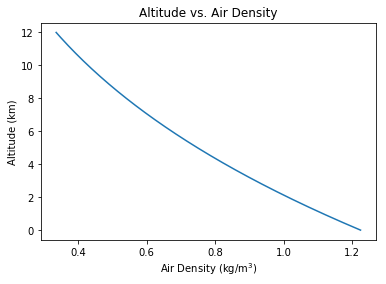

In [36]:
plot(p_a,z)
xlabel('Air Density ($\mathrm{kg/m^3}$)')
ylabel('Altitude (km)')
title('Altitude vs. Air Density')

Change in temperature is the environmental lapse rate, which can be derived from IGL, but in thunderstorms, the air isn't dry, so it doesn't apply. I looked up the average lapse rate to be 6.5 degrees C / km, which isn't perfect, but better than assuming temperature is constant. Assuming it's a warm day, we'll start at ground level at 25 degrees C.

In [38]:
#Temperature
T = 25 - z*6.5

Text(0.5, 1.0, 'Temperature vs. Altitude')

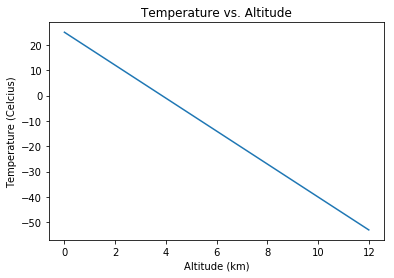

In [39]:
plot(z,T)
ylabel('Temperature (Celcius)')
xlabel('Altitude (km)')
title('Temperature vs. Altitude')

In [40]:
#constants
g = 9.8                     #easy m/s^2
P_l = 300                   #density of graupel kg/m^3
C_D = 0.6                   #graupel drag coefficient
E_gi = 1                    #value of unity ? product of collision effiency and rebound efficiency 
dq = 1.6E-14                #C/collision
N_i = 10**7                 #ice crystal concentration per m^3
n_0g = 9750000           #intercept parameters of graupel and snow distributions
Y_g = 2.67E3                #graupel slope parameter (/m)
D = linspace(0,.007,29)     #diameter of graupel in m

Text(0.5, 1.0, 'Graupel Distribution')

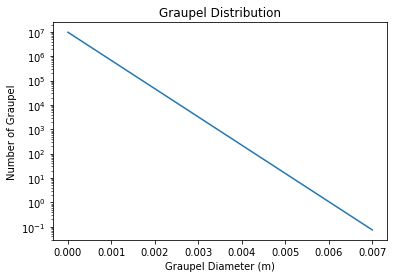

In [41]:
#graupel distribution
n = n_0g * exp(-Y_g * D)

plot(D,n)
yscale("log")
xlabel('Graupel Diameter (m)')
ylabel('Number of Graupel')
title('Graupel Distribution')

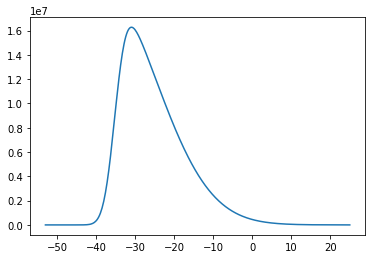

In [42]:
#ice crystal concentration
N_i = 10**7 * exp(-(.05*(T+39))**2) * (1 + erf(.3*(T+35)))
plot(T,N_i)

Text(0.5, 1.0, 'Ice Crystal Concentration')

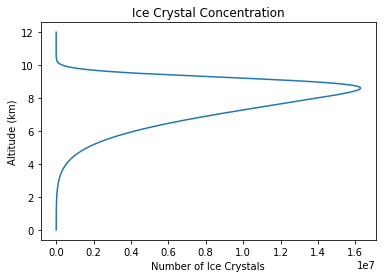

In [43]:
plot(N_i,z)
xlabel('Number of Ice Crystals')
ylabel('Altitude (km)')
title('Ice Crystal Concentration')

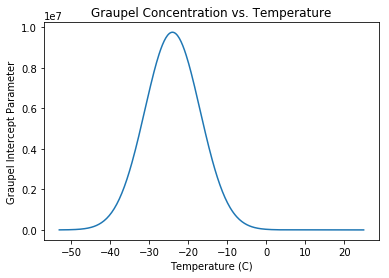

In [44]:
#graupel base distribution concentration
n_0g = 9750000 * exp(-((T+24)/10)**2)
xlabel('Temperature (C)')
ylabel('Graupel Intercept Parameter')
title('Graupel Concentration vs. Temperature')
plot(T,n_0g)

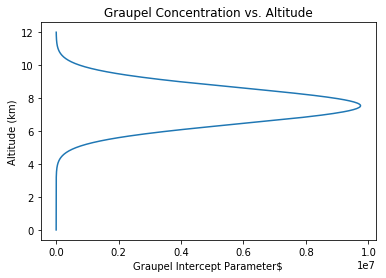

In [45]:
ylabel('Altitude (km)')
xlabel('Graupel Intercept Parameter$')
title('Graupel Concentration vs. Altitude')
plot(n_0g,z)

In [46]:
#the noninductive charge generation equation for graupel & ice
#all in MKS units
C = 2.61 * (4 * g * P_l / (3 * C_D * p_a))**(1/2) * E_gi * dq * N_i * n_0g * Y_g**(-3.5)

Text(0.5, 1.0, 'Charge Generation')

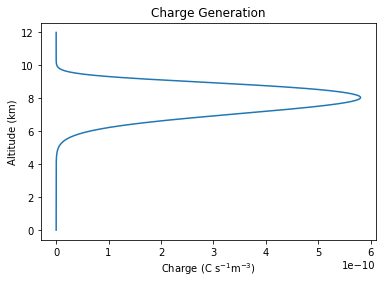

In [47]:
plot(C,z)
xlabel('Charge (C $\mathrm{s^{-1} m^{-3}}$)')
ylabel('Altitude (km)')
title('Charge Generation')

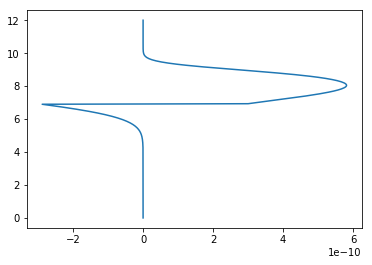

In [48]:
CC = copy(C)
neg = (T >= -20)
CC[neg] = CC[neg] * -1
plot(CC,z)

Text(0.5, 1.0, 'Charge Generation')

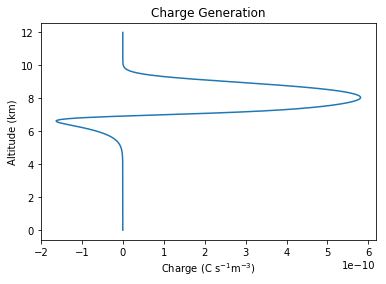

In [49]:
CC_t = C*tanh(-(T+20)*0.6)
              
plot(CC_t, z)
xlabel('Charge (C $\mathrm{s^{-1} m^{-3}}$)')
ylabel('Altitude (km)')
title('Charge Generation')

Text(0.5, 1.0, 'Current vs. Altitude')

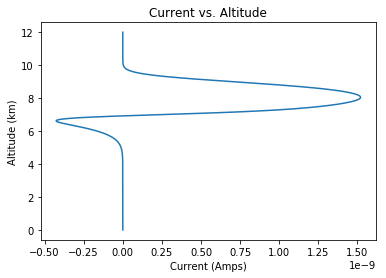

In [50]:
r = 5
dz = z[1]-z[0]
V = r**2 * pi * dz

CD = V * CC_t
plot(CD,z)
xlabel('Current (Amps)')
ylabel('Altitude (km)')
title('Current vs. Altitude')

____________________________________________________________________

In [ ]:
dV =                        #difference in sedimentation speeds for different hydrometeors
dL =                        #function of cloud water content
beta = T                    #temperature function
d = 0.0002                  #diameter of cloud droplet
E_gc = .01 * exp(.01*T)     #graupel-droplet collision efficiency
n_c =                       #numerical concentration of hydrometeors
alpha = 0.022                #rebound probability and droplets w/ grazing trajectories
e = 1.0005898                 #dielectric permittivity of air
cos = 0.84                   #cosine of angle between cloud droplet and graupel
E_r = 0.1                    #probility of cloud droplet collision
E_z =                       #vertical eletric field in thunderstorm
Q_d = p_g/N_g                       #individual charge. N_g is graupel concentration
V_D =                        # fall speed 
#the inductive charge generation equation
S = pi / 4 * E_gc * E_r * D**2 * V_D * n_c * alpha * ((pi**3 / 2) * (d)**2 * e * E_z * cos - (pi**2/6 * Q_d * d**2 / D**2))